In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from utils import setup_seed
import numpy as np
from tqdm import tqdm

plt.style.use("ggplot")
plt.rcParams["font.sans-serif"] = ["Maple Mono NF CN"]

In [13]:
class CenterLoss(nn.Module):
    """
    根据论文公式 (2) 实现: L_C = 1/2 * sum(||x_i - c_{y_i}||^2)
    """

    def __init__(self, num_classes=10, feat_dim=128):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        # 初始化中心参数 [cite: 167]
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, x, labels):
        """
        x: 深度特征 (batch_size, feat_dim) [cite: 91]
        labels: 对应的类别标签 (batch_size)
        """
        batch_size = x.size(0)
        # 计算特征与对应中心点之间的欧氏距离平方
        center_batch = self.centers[labels]
        loss = (x - center_batch).pow(2).sum() / 2.0 / batch_size
        return loss


In [14]:
@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_correct, total = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_correct / total


In [15]:
# --- 模型定义 ---


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, feat_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc_feat = nn.Linear(128, feat_dim)
        self.fc_out = nn.Linear(feat_dim, num_classes)

    def forward(self, x, return_feat=False):
        h = self.conv(x).view(x.size(0), -1)
        z = self.fc_feat(h)
        # 注意：论文通常建议在计算 Center Loss 的特征层不加 ReLU，
        # 以防止特征塌陷到第一象限，这里保留你的模板逻辑
        z = F.relu(z)
        out = self.fc_out(z)
        if return_feat:
            return out, z
        return out


setup_seed(4)
# --- 训练配置 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
lr_model = 0.001
lr_cent = 0.5  # 论文中的标量 alpha，用于控制中心点的更新速率 [cite: 150, 168]
lamda = 0.003  # 论文推荐的平衡系数 lambda

# 数据加载
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
transform_test = transforms.Compose([transforms.ToTensor()])
train_set = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
# train_sub_set = torch.utils.data.Subset(train_set, range(0, 10000))
test_set = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256)


# 初始化
model = SimpleCNN().to(device)
criterion_softmax = nn.CrossEntropyLoss()
criterion_center = CenterLoss().to(device)

# 优化器设置 [cite: 177, 178]
optimizer_model = optim.Adam(model.parameters(), lr=lr_model)
optimizer_center = optim.Adam(criterion_center.parameters(), lr=lr_cent)

# --- 训练循环 ---
model.train()
train_acc_list, test_acc_list = [], []
for epoch in tqdm(range(1, 51)):
    total_loss, total_correct, total = 0, 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # 前向传播获取特征
        output, features = model(data, return_feat=True)

        # 计算联合损失
        loss_s = criterion_softmax(output, target)
        # loss_c = criterion_center(features, target)
        loss = loss_s  # + lamda * loss_c

        # 反向传播与参数更新 [cite: 177, 180]
        # 3. 清空两个优化器的梯度
        optimizer_model.zero_grad()  # 标准 PyTorch 方法
        # optimizer_center.zero_grad()  # 修正此处：统一使用 zero_grad()
        loss.backward()
        optimizer_model.step()

        # 按照 Algorithm 1 更新类别中心
        # optimizer_center.step()

        total_loss += loss.item()
        total_correct += (output.argmax(1) == target).sum().item()
        total += data.size(0)
    train_acc = total_correct / total
    test_acc = eval_epoch(model, test_loader, device)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)


/home/ling/ws/pyWS/pacr/.venv/lib64/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")
100%|██████████| 50/50 [03:37<00:00,  4.34s/it]


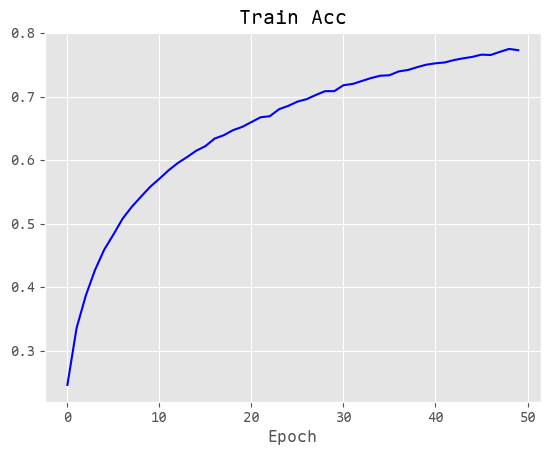

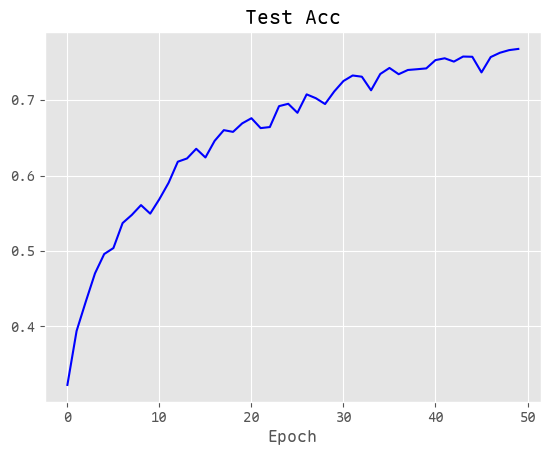

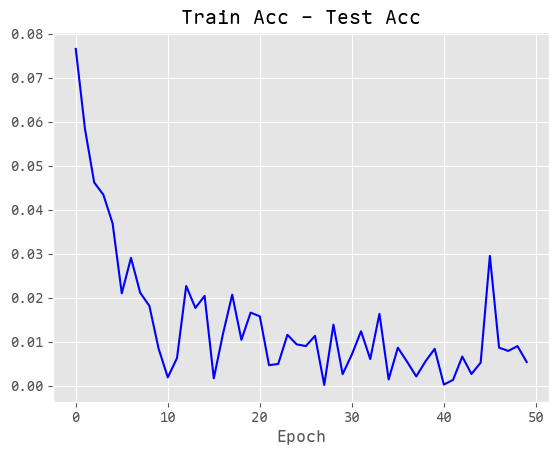

In [16]:
fig, ax = plt.subplots()
ax.plot(train_acc_list, "b")
ax.set_xlabel("Epoch")
ax.set_title("Train Acc")
plt.show()
fig, ax = plt.subplots()
ax.plot(test_acc_list, "b")

ax.set_xlabel("Epoch")
ax.set_title("Test Acc")
plt.show()
fig, ax = plt.subplots()
ax.plot(np.abs(np.array(train_acc_list) - np.array(test_acc_list)), "b")
ax.set_xlabel("Epoch")
ax.set_title("Train Acc - Test Acc")
plt.show()


In [17]:
test_acc_list[-1]

0.7677